MLP model for predicting (unfiltered) shear stress

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(1)
import tensorflow as tf
#tf.random.set_seed(1)


Using TensorFlow backend.


In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [3]:
# Load the data

data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/p5270MechData/p5270MechData.mat')

m_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'ShearStress':data2['ShearStress'].ravel()})
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'A_filt':data1['A_filt'].ravel(), 'V_filt':data1['V_filt'].ravel(),
                    'T_pc':data1['T_pc'].ravel(), 'Vel_pc':data1['Vel_pc'].ravel(), 'T_der':data1['T_der'].ravel(), 'Vel_der':data1['Vel_der'].ravel()}) # 7 features
                   #'T_off':data1['T_off'].ravel(), 'Vel_off':data1['Vel_off'].ravel()})   

df = a_t.merge(m_t, on='Time')

print("Input data:", df.shape)


Input data: (132399, 8)


In [4]:
# Preprocessing

df = df.drop(['Time', 'Vel_der', 'T_der'], axis=1)  # Drop irrelevant features

arr = df.to_numpy()
n_steps = 1
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

Features shape, X =  (132399, 1, 4)
Target shape, Y =  (132399,)


In [5]:
# Reshape features from 3D to 2D (for input layer)

print('Before reshaping:', xdf[0])
n = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], n))
print('After reshaping:', xdf[0])

Before reshaping: [[1804.18      5489.9785293    0.           0.       ]]
After reshaping: [1804.18      5489.9785293    0.           0.       ]


In [6]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95327, 4)
Validation: (10592, 4)
Testing: (26480, 4)


Train on 95327 samples, validate on 10592 samples
Epoch 1/30
95327/95327 [==============================] - 9s 94us/step - loss: 0.2807 - val_loss: 0.0023
Epoch 2/30
95327/95327 [==============================] - 8s 88us/step - loss: 0.0039 - val_loss: 0.0046
Epoch 3/30
95327/95327 [==============================] - 8s 87us/step - loss: 0.0039 - val_loss: 0.0031
Epoch 4/30
95327/95327 [==============================] - 8s 88us/step - loss: 0.0038 - val_loss: 0.0021
Epoch 5/30
95327/95327 [==============================] - 8s 88us/step - loss: 0.0038 - val_loss: 0.0020
Epoch 6/30
95327/95327 [==============================] - 8s 87us/step - loss: 0.0037 - val_loss: 0.0021
Epoch 7/30
95327/95327 [==============================] - 8s 87us/step - loss: 0.0037 - val_loss: 0.0034
Epoch 8/30
95327/95327 [==============================] - 8s 88us/step - loss: 0.0036 - val_loss: 0.0022
Epoch 9/30
95327/95327 [==============================] - 8s 88us/step - loss: 0.0035 - val_loss: 0.0022
Epoch

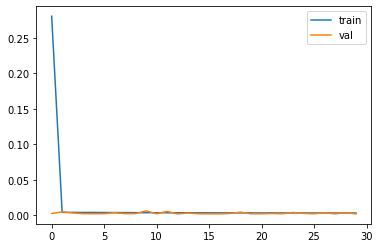

In [7]:
# Build the model

model = Sequential()
model.add(Dense(512, kernel_initializer = 'normal', input_dim = n, activation='relu'))
model.add(Dense(256, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(32, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(1, kernel_initializer = 'normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


In [8]:
# Save the model

print(model.summary())
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/MLP_unfilt.h5')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2560      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 142,145
Trainable params: 142,145
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

y_predTest = model.predict(x_test)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))


R2 scores: Train - 0.84730, Validation - 0.92118, Test - 0.85138
RMSE scores: Train - 0.05093, Validation - 0.04182, Test - 0.05685


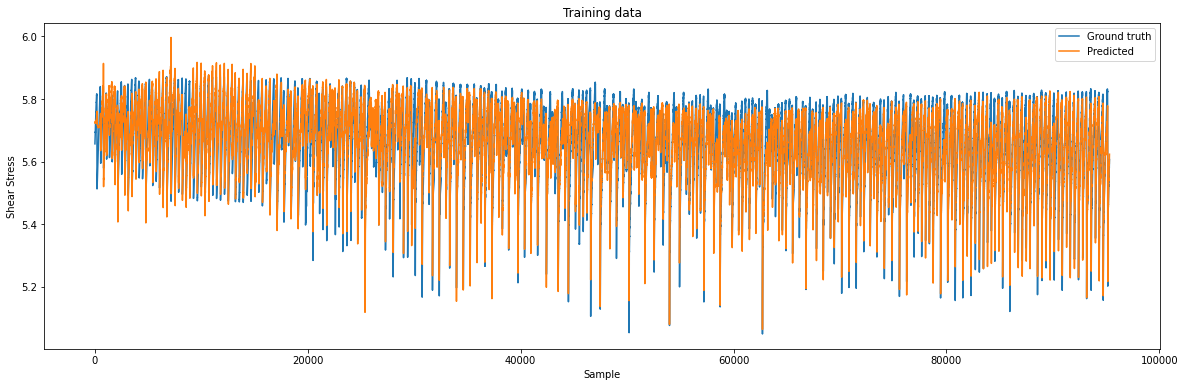

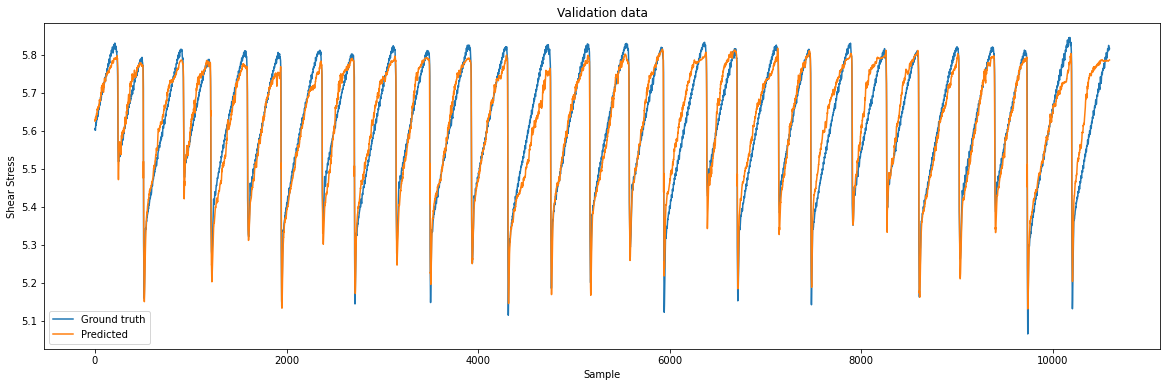

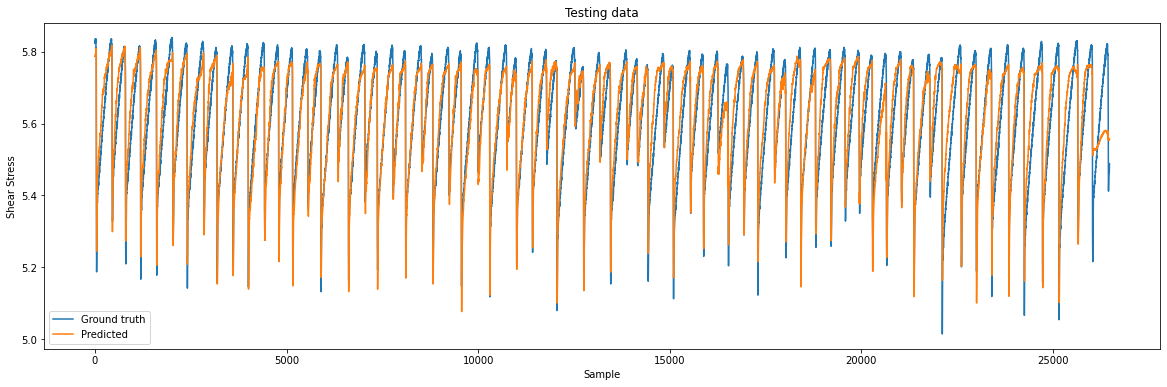

In [10]:
# Results plot

def results_plot(fig_no, gt, pred, title):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Sample')
  plt.ylabel('Shear Stress')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data')
results_plot(2, Y_val, y_predVal, 'Validation data')
results_plot(3, y_test, y_predTest, 'Testing data')


Text(0.5, 1.0, '5000 Samples, Testing Data')

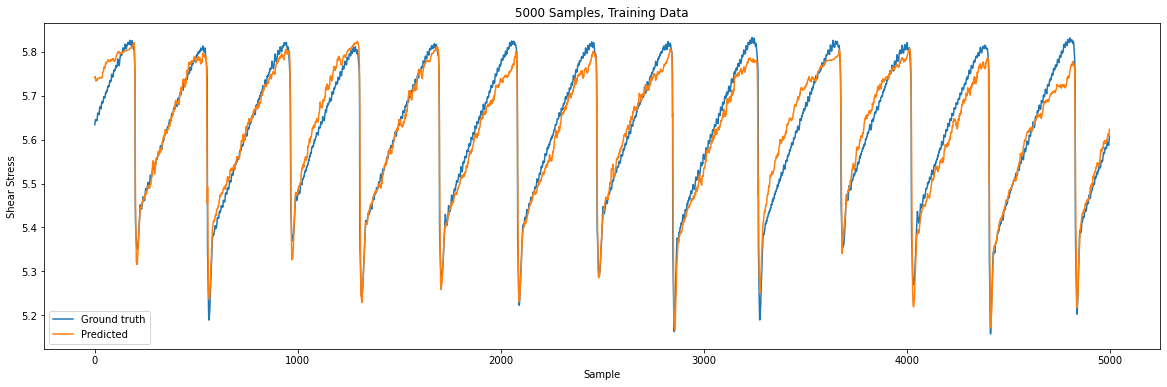

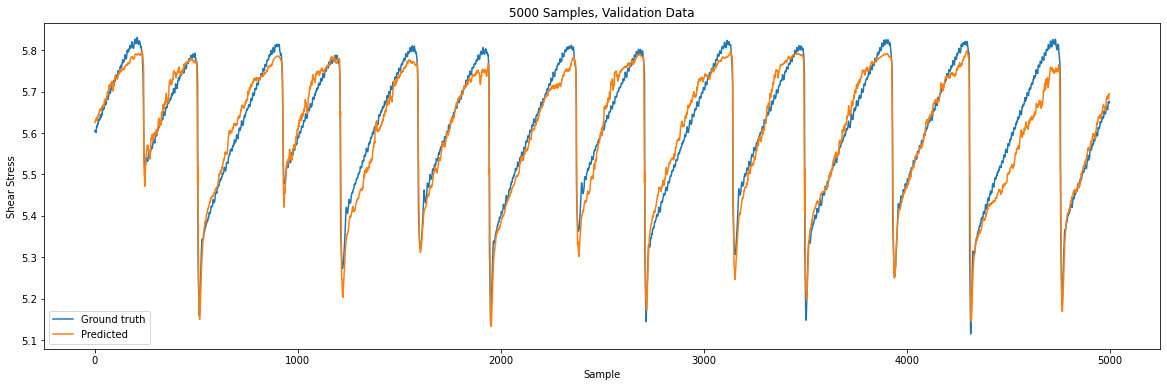

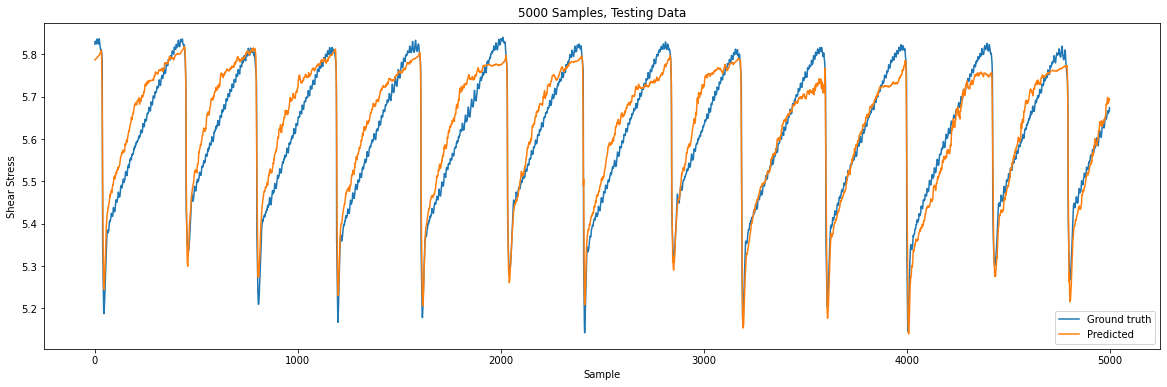

In [11]:
# Detailed view of the plots

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-5000:])
plt.plot(y_predTrain[-5000:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:5000])
plt.plot(y_predVal[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:5000])
plt.plot(y_predTest[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Testing Data')
